# gpt-image-1 on Azure AI Foundry - Image Inpainting

<img src="https://azure.microsoft.com/en-us/blog/wp-content/uploads/2025/04/Azure-AI-ML-Scene-3.png" width=300>

https://azure.microsoft.com/en-us/blog/unveiling-gpt-image-1-rising-to-new-heights-with-image-generation-in-azure-ai-foundry/?msockid=2e39c66c693c66a5151fd200687567d0

Source: https://github.com/Azure-Samples/visionary-lab/tree/main


In [1]:
import base64
import datetime
import os
import re
import requests
import sys
import time

from dotenv import load_dotenv
from io import BytesIO
from openai import AzureOpenAI
from PIL import Image
from rembg import remove

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
datetime.datetime.today().strftime('%d %b %Y %H:%M:%S')

'29 Apr 2025 16:18:12'

In [4]:
load_dotenv("azure.env")

api_version = "2025-04-01-preview"

In [5]:
model="gpt-image-1"

In [6]:
IMAGES_DIR = "images"

In [7]:
RESULTS_DIR = "results"

os.makedirs(RESULTS_DIR, exist_ok=True)

## 1. Mask-based inpainting

In [8]:
def image_inpainting(initial_image, prompt, n=1):
    """
    Performs image inpainting using Azure OpenAI's inpainting endpoint by removing the background from 
    the input image and applying edits guided by a text prompt.

    Parameters:
        initial_image (str): Path to the original image that will be inpainted.
        prompt (str): Text description guiding the inpainting process.
        n (int, optional): Number of inpainted images to generate. Defaults to 1.

    Returns:
        list[str] or None: A list of file paths to the saved inpainted images if successful,
                           or None if an error occurs.

    The function:
        - Removes the background from the original image to generate a mask.
        - Sends both the original image and mask to the Azure inpainting endpoint along with a prompt.
        - Decodes and displays each returned image.
        - Saves the resulting images to a predefined results directory.
        - Returns a list of paths to the generated images.
    """
    try:
        # Removing the background if the initial image with rembg
        processed_image = os.path.join(RESULTS_DIR, "nobackground.jpg")

        with open(initial_image, 'rb') as i:
            with open(processed_image, 'wb') as o:
                input = i.read()
                output = remove(input)
                o.write(output)

        # Headers and key
        headers = {"api-key": os.getenv("key")}
        aoai_name = re.search(r'https://(.*?)/openai', os.getenv("endpoint")).group(1)
        url = f"https://{aoai_name}/openai/deployments/{model}/images/edits?api-version=2025-04-01-preview"

        files = {
            "image": open(initial_image, "rb"),
            "mask": open(processed_image, "rb"),
        }
        data = {
            "prompt": prompt,
            "n": n,
            "size": "1024x1024", # Options: 1024x1024, 1536x1024, 1024x1536
            "quality": "high",  # high, medium, low
            "moderation": "low"
        }

        # Send the request
        response = requests.post(url, headers=headers, files=files, data=data)
        response.raise_for_status()

        images_data = response.json()["data"]
        encoded_images = [img["b64_json"] for img in images_data]

        output_images_list = []
        
        for encoded_image in encoded_images:
            img = Image.open(BytesIO(base64.b64decode(encoded_image)))
            # Saving image to a file
            now = str(datetime.datetime.today().strftime("%Y%m%d_%H%M%S_%f")[:-3])
            output_file = os.path.join(RESULTS_DIR, f"inpainting_{now}.jpg")
            img.save(output_file)
            print(f"File saved: {output_file}")
            output_images_list.append(output_file)

    except Exception as e:
        print(f"Error generating images: {e}")
        return None

    return output_images_list

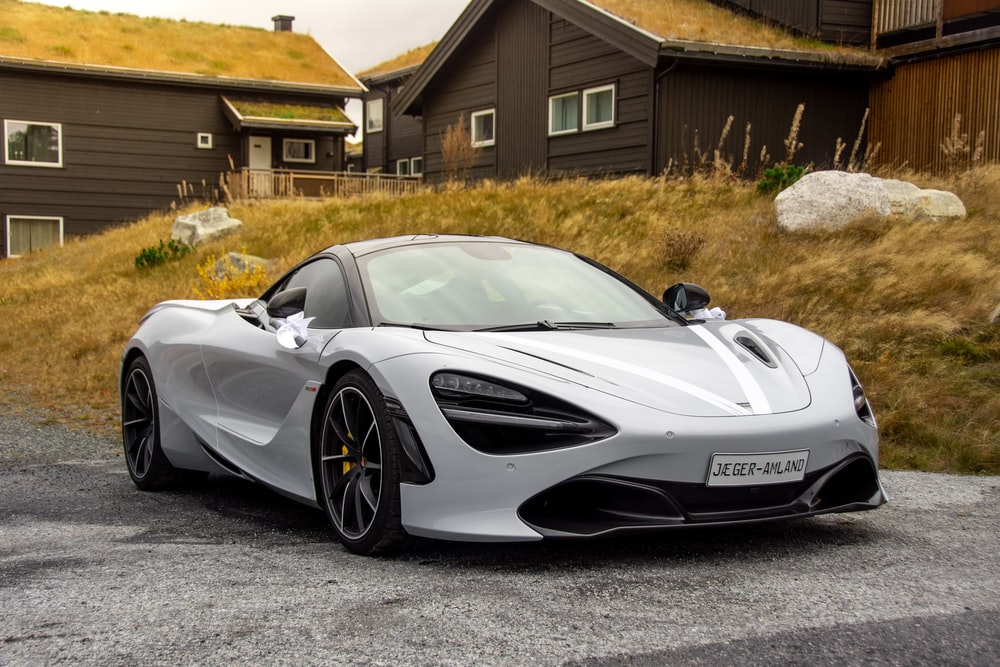

In [9]:
initial_image = os.path.join(IMAGES_DIR, "car.jpg")

img = Image.open(initial_image)
img

In [12]:
prompt = "Add a busy street in the background. We must see the Eiffel tower in the background"

images_list = image_inpainting(initial_image, prompt, 1)

File saved: results/inpainting_20250429_162023_084.jpg


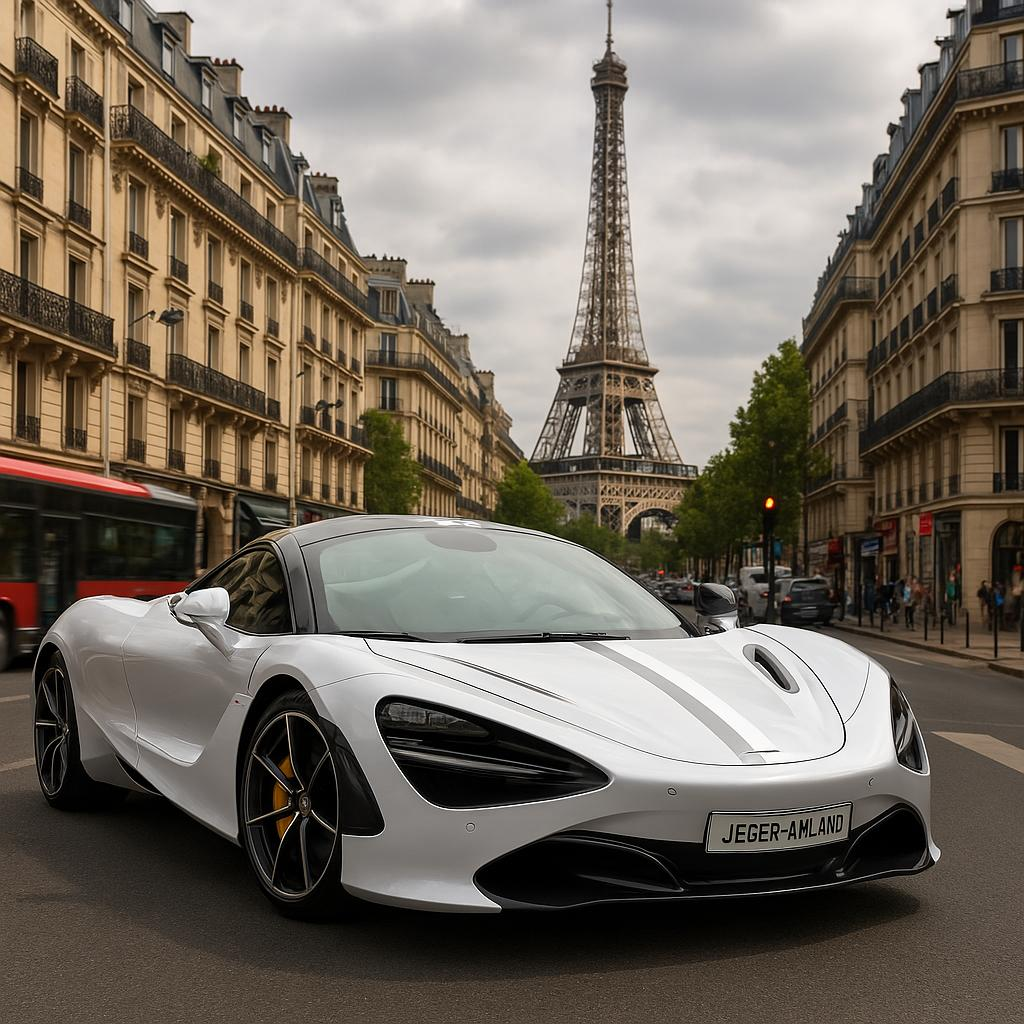

In [13]:
img = Image.open(images_list[0])
img

In [16]:
prompt = "The car should be close to the sea. Change the color of the car to red. Change the licence plate to 'I am a red car'"

images_list = image_inpainting(initial_image, prompt, 1)

File saved: results/inpainting_20250429_162315_789.jpg


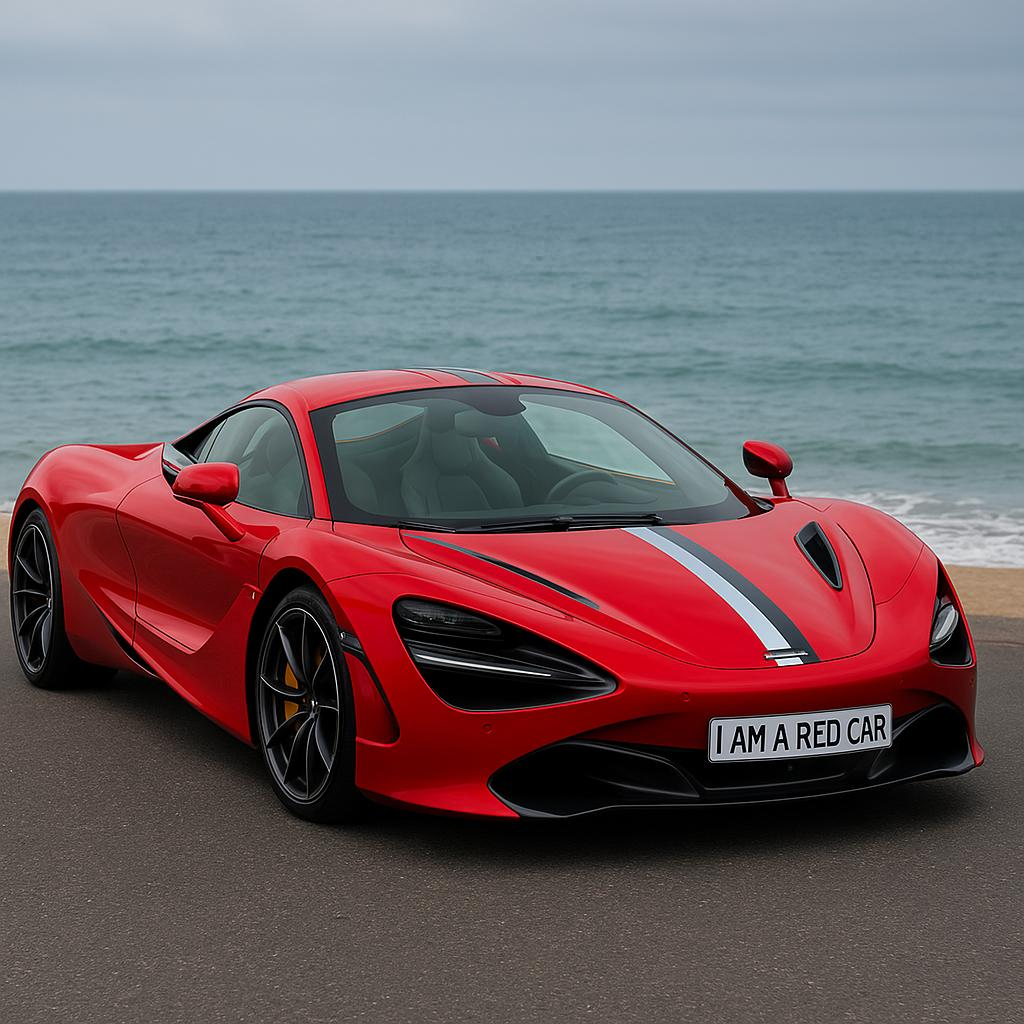

In [17]:
img = Image.open(images_list[0])
img

In [18]:
prompt = "Change the color car to blue, white and red. Add a transparent background."

images_list = image_inpainting(initial_image, prompt, 1)

File saved: results/inpainting_20250429_162540_265.jpg


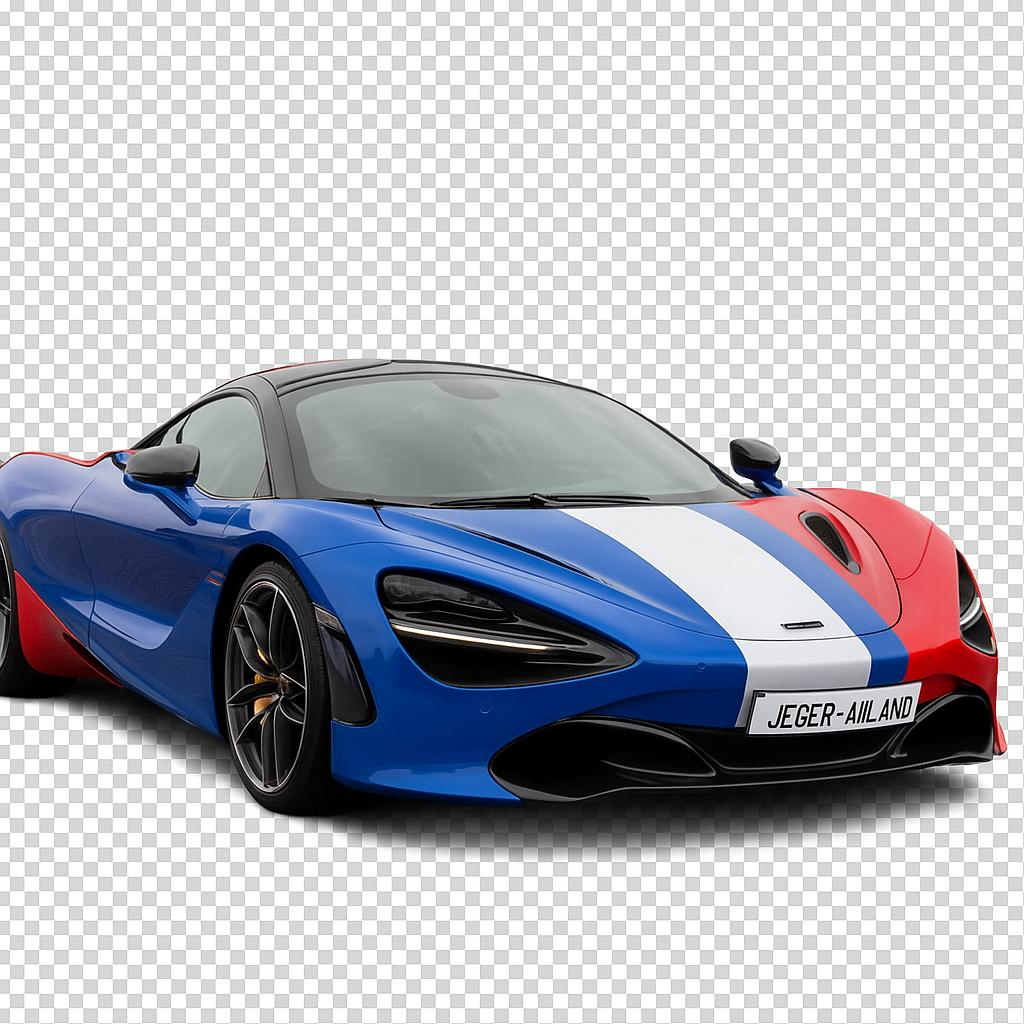

In [19]:
img = Image.open(images_list[0])
img